# Real-time multiple face detection with OpenFace
** Nguyen Dang Minh, PhD **

* [**1. Introduction**](#ch1)
* [**2. Face detection and image processing**](#ch2)
    * [2.1. Face detection and aligment](#ch2.1)
    * [2.2. Data augmentation](#ch2.2)
* [**3. The OpenFace CNN**](#ch3)
* [**4. Face recognition**](#ch4)
    * [4.1. Face recognition from photo](#ch4.1)
    * [4.2. Face recognition from webcam video](#ch4.2)


<a id="ch1"></a>

## 1. Introduction

This is a face identification project, which is inspired by [Andrew Ng's Coursera course on Convolutional Neural Network](https://www.coursera.org/learn/convolutional-neural-networks). Sure, a lot of people has done face recognition before. Especially after the infamous [FaceNet paper](https://arxiv.org/abs/1503.03832) goes online, the solution to this problem is signficiantly improved. In fact, the core of my work here is based on that paper. However, the problem is that the OpenFace model is limited to image that contains **one and only one face**. You give it an image of a single person, it gives you the his/her name. You give it a group image, like the one below, then it will fail to do the job. The performance is also affected by the face's orientation, size and brightness. For example, a portrait might give you different result compared to a full body image.

<img src="test.jpg" width="600px"></img>
<caption><center>**A group photo where the original OpenFace algorithm will not work**<br> </center></caption>

The goal of the project is to build a system that can **detect and identifiy all people** whose faces are presented in a picture or a real-time captured video. The following steps were taken in order to accomplish that task:

* **Step 1**: Preprocess the image to standardize the input, to detect and extract all the human face feature presented. Here I used [Dlib](http://dlib.net) and [OpenCV](https://opencv.org/) libraries for this task.
* **Step 2**: Construct a Convolutional Neural Network (CNN) that takes images as input and return its *embedding* values, which is a 128-dimensional array. The Euclidan distance between two *embeddings* represents the face similarity. Here I use the [OpenFace](https://cmusatyalab.github.io/openface/) pre-trained model for this task.
* **Step 3**: Take the preprocessed image from **step 1** and pass it through the CNN built in **step 2**, then compared its embedding value with a prepared database and return the identity of the person with smallest embedding difference.

In this project the following utilitiy files are imported:
* `facerecog_utils.py`: to preprocess the image and compare the embedding values with the database.
* `database_utils.py`: to perform data augmentation and generate the database to be used in **step 3**
* `align.py`: to detect all faces in the image align it so that the person eyes are oriented horizontally at a proper height ratio of the whole face. This code is taken from the OpenFace project.
* `inception_blocks.py`: to construct the architecture of the CNN. The code is taken from Andrew Ng Convolutional Neural Network course, assignment 3.

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model, load_model, model_from_json
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
from keras.preprocessing.image import ImageDataGenerator

import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import skimage as sk
import time

from facerecog_utils import *
from database_utils import *
from align import AlignDlib
from inception_blocks import *

Using TensorFlow backend.


<a id="ch2"></a>

## 2. Face detection and image processing

<a id="ch2.1"></a>

### 2.1 Face detection and alignment

In order to achieve the best performance, our input images should have similar properties to the ones used to train the CNN model. Thus the first step of the project is to be able to extract all the face presented and perform proper transformations so that the model input meets the following requirements:

* The image size should be 96 pixels $\times$ 96 pixels
* Only **one single face** is allowed in the image
* The face needs to be aligned so that the line connecting two eyes is horizontally oriented and located 20 pixel from the image top.

There are some pretrained libraries for this task, here I use the [AlignDlib](https://github.com/krasserm/face-recognition/blob/6e80ac75c805f49f7aa1acc7f21f2ed6c8f9b5cc/align.py) utility from the OpenFace project which detect and align the face based on a pre-trained landmarks. Another option is to use the pre-trained [Haar_cascade_frontalface](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) from OpenCV. However, this option does not cover the alignment task.

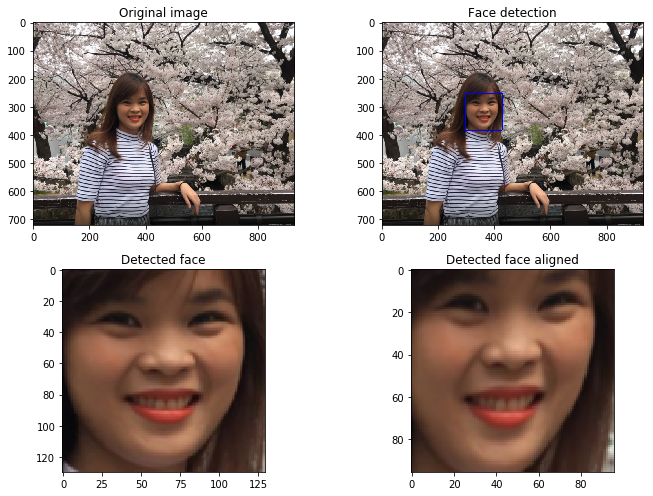

In [8]:
# Get the landmark data
alignment = AlignDlib('Libraries/landmarks.dat')

# Import the image and extract feature
img_path = 'Database/Minh_Thuong/Minh_Thuong_003.png'
img_orig = import_image(img_path)
face_list, face_pos, img_face = get_faces_from_image(img_orig, plot=False)
this_face = face_list[0]
this_face_align = face_aligned(img_orig)

# Showing the results
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(221)
ax1.set_title('Original image')
plt.imshow(img_orig)
ax2 = fig.add_subplot(222)
ax2.set_title('Face detection')
plt.imshow(img_face)
ax3 = fig.add_subplot(223)
ax3.set_title('Detected face')
plt.imshow(this_face)
ax4 = fig.add_subplot(224)
ax4.set_title('Detected face aligned')
plt.imshow(this_face_align)
plt.tight_layout()

<a id="ch2.2"></a>

### 2.2 Data augmentation

The more data we have, the better chance that we do our job right. However, data is expensive so we need to make the best out of what we have. Here, I will generate more data for the database by modifying the original image's orientation, brightness and contrast. This will also helps reduce the effect of the photo's orientation and lighting when it comes to the actual job. 

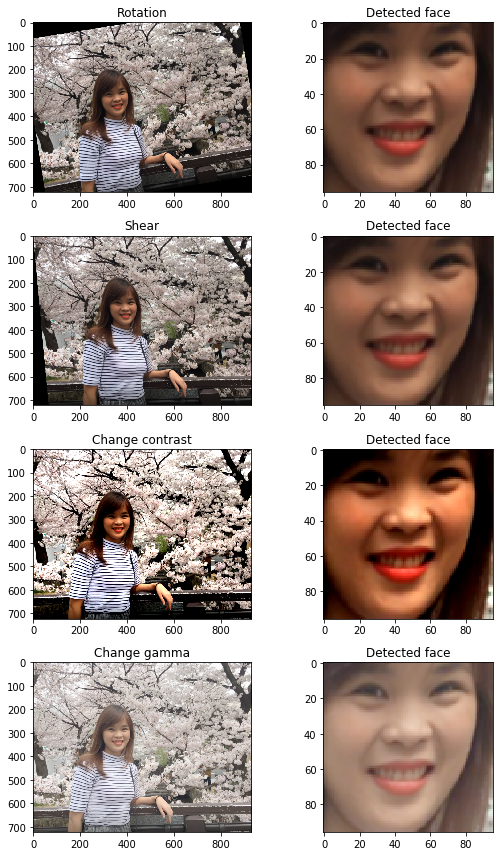

In [5]:
img_path = 'Database/Minh_Thuong/Minh_Thuong_003.png'
img_orig = import_image(img_path)

img_rotate = random_rotate(img_orig)
img_shear = random_shear(img_orig)
img_contrast = change_contrast(img_orig, percent_change=(10,20))
img_gamma = gamma_correction(img_orig,gamma_range=(0.5,0.6))

fig = plt.figure(figsize=(8,12))

ax1 = fig.add_subplot(421)
ax1.set_title('Rotation')
plt.imshow(img_rotate)
ax2 = fig.add_subplot(422)
ax2.set_title('Detected face')
plt.imshow(face_aligned(img_rotate))

ax3 = fig.add_subplot(423)
ax3.set_title('Shear')
plt.imshow(img_shear)
ax4 = fig.add_subplot(424)
ax4.set_title('Detected face')
plt.imshow(face_aligned(img_shear))

ax5 = fig.add_subplot(425)
ax5.set_title('Change contrast')
plt.imshow(img_contrast)
ax6 = fig.add_subplot(426)
ax6.set_title('Detected face')
plt.imshow(face_aligned(img_contrast))

ax7 = fig.add_subplot(427)
ax7.set_title('Change gamma')
plt.imshow(img_gamma)
ax8 = fig.add_subplot(428)
ax8.set_title('Detected face')
plt.imshow(face_aligned(img_gamma))

plt.tight_layout()

<a id="ch3"></a>

## 3. The OpenFace CNN

After taking care of the preprocessing step, now let's dive in the core of the program: the OpenFace CNN.

As mentioned previosuly, the OpenFace CNN is built based on the [FaceNet paper](https://arxiv.org/abs/1503.03832). The basic idea is that, **instead of training the neural network to identify person by person, it trains the network to tell if the two images belong to the same person or not**. To do that, the training step will take three input images: an anchor image of the test subject ($x_a$), a positive image of the same person ($x_p$) and a negative image of a different person ($x_n$). The network will then attempt to minimize the distance between $x_a$ and $x_p$ while trying to maximize the distance between $x_a$ and $x_n$ by applying a triplet-loss function. For more details, you can refer to the aforementioned paper, or take a look at Andrew Ng course, which gives a both detailed and simple explanation. Now let's just jump to the model structure.

In [2]:
# Load the pretrained CNN models
FRmodel = faceRecoModel(input_shape=(3,96,96))
FRmodel.load_weights('Libraries/nn4.small2.v1.h5')
FRmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 3, 102, 102)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 48, 48)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 64, 48, 48)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

The model structure is complicated, but to utilize it, we only need to know that the input dimension is 3(channels) $\times$ 96(pixels) $\times$ 96(pixels). After several convolutional layers which consists of inception network, it returns an output with dimension of 1 $\times$ 1 $\times$ 128, which is the embedding of the image. Should the model work properly, images of the same person will have small embedding distance, while different person will return large embedding distance.

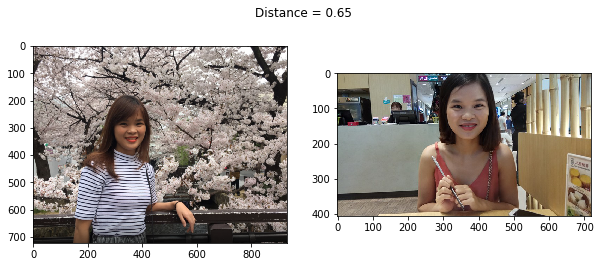

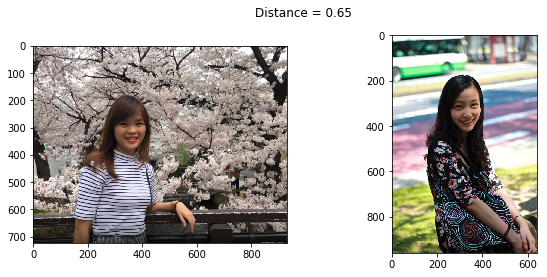

In [8]:
# Import image
anchor_path = 'Database/Minh_Thuong/Minh_Thuong_003.png'
anchor_img = import_image(anchor_path)
pos_path = 'Database/Minh_Thuong/Minh_Thuong_002.jpg'
pos_img = import_image(pos_path)
neg_path = 'Database/Linh_Chu/Linh_Chu_001.jpg'
neg_img = import_image(neg_path)

# Embedding without face extraction
show_pair(anchor_img, pos_img, FRmodel, aligned=False)
show_pair(anchor_img, neg_img, FRmodel, aligned=False)

Here both negative and positive input return the same distance. The reason is that the images **did not go through the extraction and alignment step**. Thus the model will compare the whole pictures, not only the face but also the body as well as background. The performance is significantly improved when the pre-processing step is introduced.

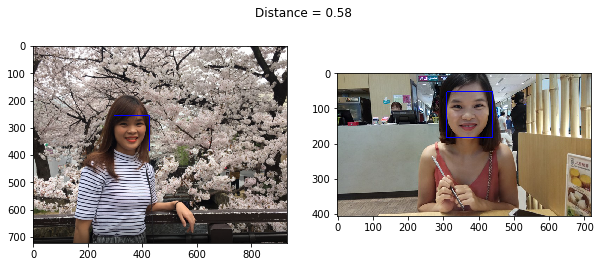

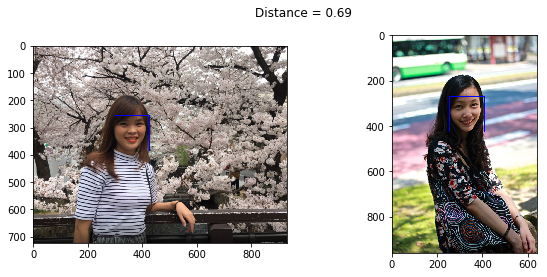

In [9]:
# Image embedding with face extraction
show_pair(anchor_img, pos_img, FRmodel, aligned=True)
show_pair(anchor_img, neg_img, FRmodel, aligned=True)

Once **Step 1** and **Step 2** are completed, we prepare for the recognition task by generating a database. Here I collected some pictures of my friends from their facebook, augment them and pass those images through the neural network. The embedding values are then stored in a dictionary for the comparison task.

In [14]:
# Generate the database
generate_database('Database/Friends', FRmodel, augmentations=3, output_name='friends.npy')      

In [3]:
# Load the database
face_dict = np.load('friends.npy').item()

<a id="ch4"></a>

## 4. Face recognition

<a id="ch4.1"></a>

### 4.1 Face recognition from photo

The code completes the face recognition task by following these step:
* Detect, extract and align all faces presented in the picture.
* Pass all the output faces to the CNN, which return the corresponding embedding values.
* For each face, calculate its embedding distance with all the values stored in the database and return the identity of the person with smallest distance
* Attached the label to the corresponding face in the original image

Total run time: 1324.02 ms


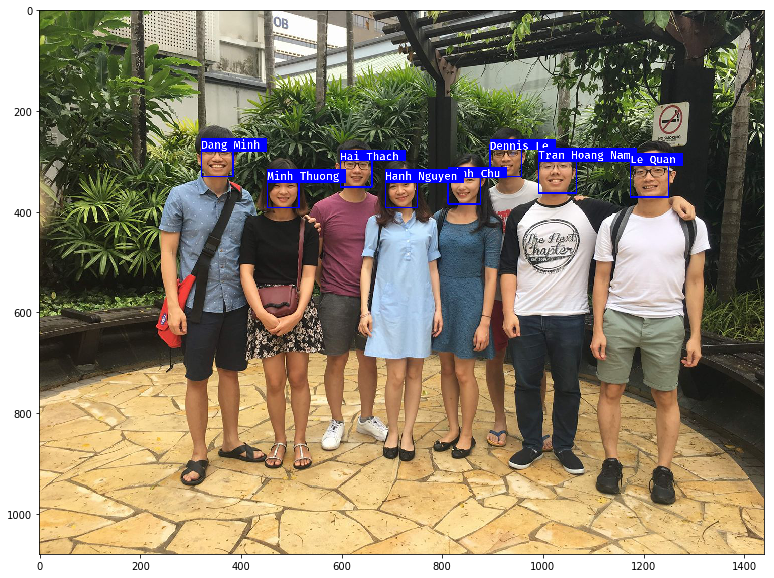

In [5]:
# Import image
img_path = 'test.jpg'
image = import_image(img_path)

# Face recognition
time_start = time.time()
plt.figure(figsize=(15,10))
face_out = face_recognition(image, FRmodel, face_dict, plot=True, faces_out=True)
time_end = time.time()
print('Total run time: %.2f ms' %((time_end-time_start)*1.e3))

Now let's print all the face detected with corresponding label

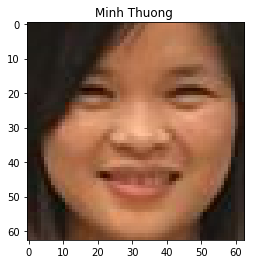

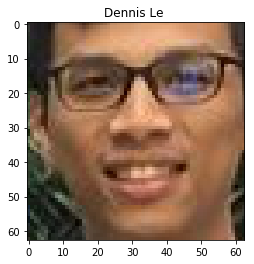

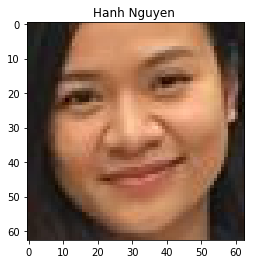

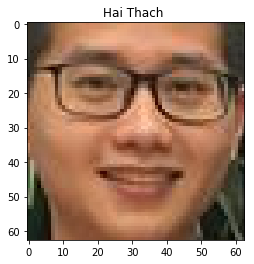

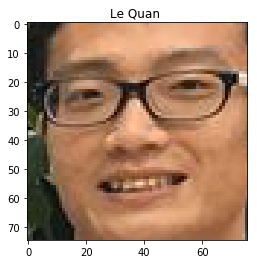

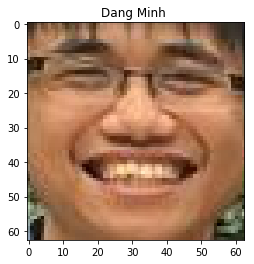

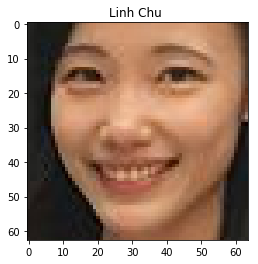

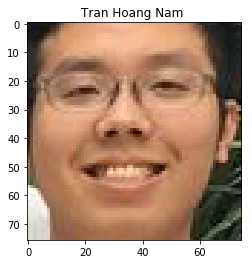

In [6]:
for name in face_out.keys():
    this_face = face_out[name]
    fig = plt.figure()
    plt.imshow(this_face)
    plt.title(name)

<a id="ch4.2"></a>

### 4.2 Face recognition from webcam video

To upgrade from working with a single image to working with a webcam recording, we simply need to add a code that collect and preprocess frame-by-frame of the video and pass it to the CNN as a stream of single image.

In [ ]:
video = cv2.VideoCapture(0)

# Capture continuously
a = 0
while True:
    a = a+1
    check, frame = video.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_show = face_recognition(frame, FRmodel, database=face_dict, plot=False)
    img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    cv2.imshow('Capturing', img_show)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    
video.release()

Here is an example of the face-recognition results taken from my webcam.

<img src="face_recog.gif" width="800" />